In [1]:
import os
import sys

root_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(root_path)

import time
import torch
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import torchvision as tv
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    EarlyStopping,
)
from src.utils.helpers import load_config
from src.training.dataset import ImageDataModule
from src.models.classification_model import ImageClassifier

C:\Users\camme\anaconda3\envs\DL_FinalProject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\camme\anaconda3\envs\DL_FinalProject\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
real_files = os.listdir("../../src/data/sampled/train/real")
fake_files = os.listdir("../../src/data/sampled/train/ai")

real_count, fake_count = len(real_files), len(fake_files)
print(f"REAL COUNT: {real_count} ({round(real_count/(fake_count+real_count) * 100, 1)}%)")
print(f"FAKE COUNT: {fake_count} ({round(fake_count/(fake_count+real_count) * 100, 1)}%)")

REAL COUNT: 16800 (50.0%)
FAKE COUNT: 16800 (50.0%)


In [3]:
torch.set_float32_matmul_precision("high")
config = load_config("sampled_efficientnet_b0.yaml")
pl.seed_everything(config.get("seed"))

csv_logger = CSVLogger(
    save_dir=config["logging"].get("logs_dir", "logs"),
    name=config.get("experiment_name"),
)
experiment_name = config.get("experiment_name"),

Seed set to 7643


In [4]:
callbacks = []
data_module = ImageDataModule(config)

# Initialize model:
net = ImageClassifier(config)

# Enable learning rate monitoring hook:
if config["training"].get("lr_monitoring"):
    monitor_lr = LearningRateMonitor(logging_interval="epoch")
    callbacks.append(monitor_lr)

# Enable early stopping hook:
estop = config["training"].get("early_stopping", {})
if estop.get("enabled"):
    early_stopping = EarlyStopping(
        monitor=estop.get("monitor", "val_loss"),
        patience=estop.get("patience", 5),
        mode=estop.get("mode", "min"),
        verbose=True,
    )
    callbacks.append(early_stopping)

# Enable model checkpointing hook:
checkpoint = ModelCheckpoint(
    dirpath=config["logging"].get("checkpoint_dir", "checkpoints"),
    filename="{epoch:02d}-{val_acc:.2f}",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
callbacks.append(checkpoint)

In [5]:
# Configure training session:
trainer = pl.Trainer(
    min_epochs=config["training"].get("min_epochs"),
    max_epochs=config["training"].get("max_epochs", -1),
    logger=csv_logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    enable_model_summary=True,
    devices="auto",
    accelerator="auto",
    log_every_n_steps=5,
    callbacks=callbacks,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
start = time.time()
# Begin training:
trainer.fit(
    model=net,
    datamodule=data_module,
)
end = time.time()
print(f"Took {end - start:.3f} seconds")

[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/train.
[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/validation.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | loss_func | CrossEntropyLoss | 0      | train
1 | backbone  | EfficientNet     | 4.0 M  | train
-------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/test.
Epoch 0: 100%|██████████| 350/350 [00:58<00:00,  5.98it/s, v_num=0]        
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 350/350 [01:07<00:00,  5.21it/s, v_num=0, val_loss=0.949, val_acc=0.733, train_loss=1.420, train_acc=0.667]

Metric val_loss improved. New best score: 0.949


Epoch 1: 100%|██████████| 350/350 [00:57<00:00,  6.09it/s, v_num=0, val_loss=0.949, val_acc=0.733, train_loss=1.420, train_acc=0.667]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 350/350 [01:05<00:00,  5.31it/s, v_num=0, val_loss=0.677, val_acc=0.797, train_loss=0.583, train_acc=0.814]

Metric val_loss improved by 0.271 >= min_delta = 0.0. New best score: 0.677


Epoch 2: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s, v_num=0, val_loss=0.677, val_acc=0.797, train_loss=0.583, train_acc=0.814]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 350/350 [01:05<00:00,  5.30it/s, v_num=0, val_loss=0.547, val_acc=0.830, train_loss=0.329, train_acc=0.881]

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 0.547


Epoch 3: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s, v_num=0, val_loss=0.547, val_acc=0.830, train_loss=0.329, train_acc=0.881]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, v_num=0, val_loss=0.460, val_acc=0.856, train_loss=0.195, train_acc=0.928]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.460


Epoch 4: 100%|██████████| 350/350 [00:57<00:00,  6.08it/s, v_num=0, val_loss=0.460, val_acc=0.856, train_loss=0.195, train_acc=0.928]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 350/350 [01:05<00:00,  5.32it/s, v_num=0, val_loss=0.416, val_acc=0.869, train_loss=0.123, train_acc=0.952]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.416


Epoch 5: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s, v_num=0, val_loss=0.416, val_acc=0.869, train_loss=0.123, train_acc=0.952]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 350/350 [01:06<00:00,  5.30it/s, v_num=0, val_loss=0.400, val_acc=0.881, train_loss=0.0807, train_acc=0.971]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.400


Epoch 6: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s, v_num=0, val_loss=0.400, val_acc=0.881, train_loss=0.0807, train_acc=0.971]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, v_num=0, val_loss=0.376, val_acc=0.886, train_loss=0.0529, train_acc=0.982]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.376


Epoch 7: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s, v_num=0, val_loss=0.376, val_acc=0.886, train_loss=0.0529, train_acc=0.982]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, v_num=0, val_loss=0.369, val_acc=0.893, train_loss=0.0375, train_acc=0.988]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.369


Epoch 8: 100%|██████████| 350/350 [00:57<00:00,  6.06it/s, v_num=0, val_loss=0.369, val_acc=0.893, train_loss=0.0375, train_acc=0.988]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, v_num=0, val_loss=0.362, val_acc=0.899, train_loss=0.026, train_acc=0.992] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.362


Epoch 9: 100%|██████████| 350/350 [00:57<00:00,  6.07it/s, v_num=0, val_loss=0.362, val_acc=0.899, train_loss=0.026, train_acc=0.992]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 350/350 [01:06<00:00,  5.28it/s, v_num=0, val_loss=0.359, val_acc=0.902, train_loss=0.0188, train_acc=0.996]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.359
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 350/350 [01:06<00:00,  5.26it/s, v_num=0, val_loss=0.359, val_acc=0.902, train_loss=0.0188, train_acc=0.996]
Took 724.555 seconds


In [7]:
def plot_metrics(filepath: str):
    metrics_df = pd.read_csv(filepath)
    train_acc = metrics_df["train_acc"].dropna(ignore_index=True)
    val_acc = metrics_df["val_acc"].dropna(ignore_index=True)
    train_loss = metrics_df["train_loss"].dropna(ignore_index=True)
    val_loss = metrics_df["val_loss"].dropna(ignore_index=True)

    # Losses:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax1.plot(train_loss, label="Train Loss", c="skyblue")
    ax1.plot(val_loss, label="Validation Loss", c="red")
    # Labels:
    ax1.set_title("Loss Curves")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xticks(range(0, len(train_loss)))
    ax1.grid()
    ax1.legend()
    # Accuracies:
    ax2.plot(train_acc, label="Train Accuracy", c="green")
    ax2.plot(val_acc, label="Validation Accuracy", c="purple")
    # Labels:
    ax2.set_title("Accuracy Curves")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_xticks(range(0, len(train_acc)))
    ax2.grid()
    ax2.legend()
    plt.tight_layout()
    plt.show()

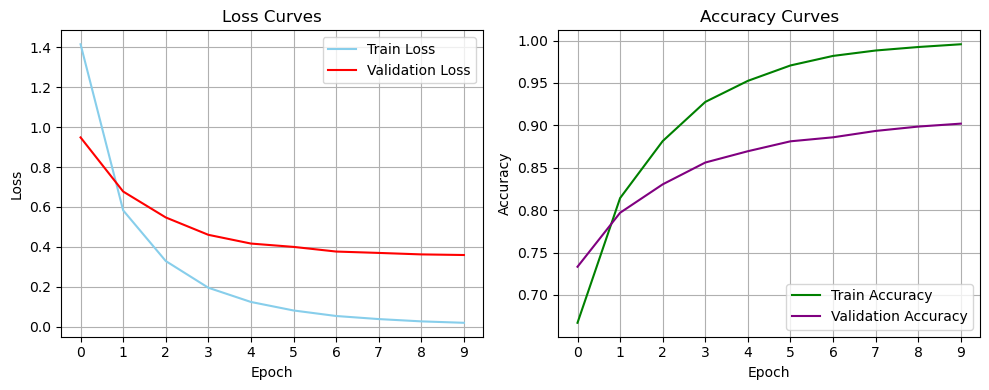

In [8]:
plot_metrics("logs/"+ experiment_name[0] +"/version_0/metrics.csv")

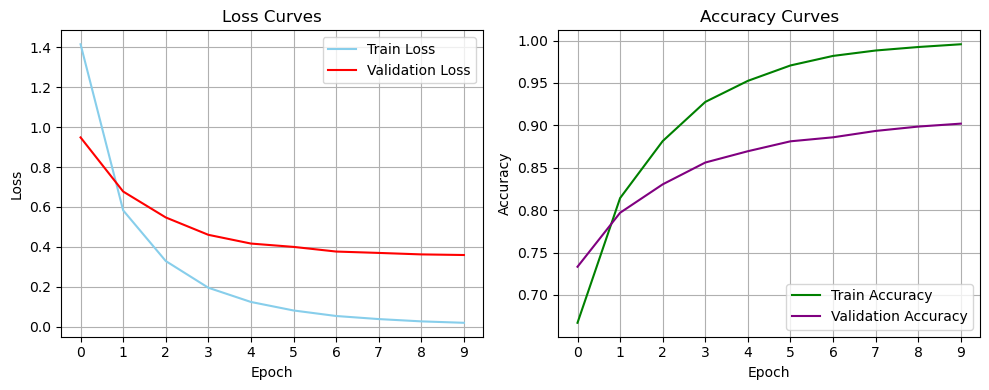

In [9]:
plot_metrics("logs/"+experiment_name[0]+"/version_0/metrics.csv")

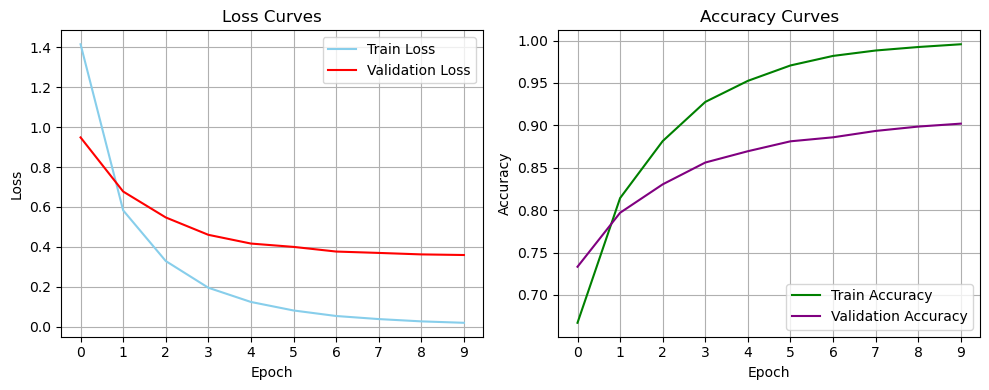

In [10]:
plot_metrics("logs/"+experiment_name[0]+"/version_0/metrics.csv")

In [11]:
# Test best model:
trainer.test(
    model=net,
    datamodule=data_module,
    ckpt_path="checkpoints/last.ckpt",
)

[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/train.
[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/validation.


Restoring states from the checkpoint path at checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at checkpoints/last.ckpt


[NOTICE] Found 0 corrupted files in ../../src/data/scaled-bilinear/test.
Testing DataLoader 0: 100%|██████████| 75/75 [00:07<00:00,  9.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9019061923027039
        test_loss           0.36375510692596436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.36375510692596436, 'test_acc': 0.9019061923027039}]